# Getting Started

This notebook will help install all the required dependencies as well as prepare the dataset for use with fast.ai

In [1]:
# Check python version
import sys
sys.version

'3.7.13 (default, Mar 29 2022, 02:18:16) \n[GCC 7.5.0]'

In [2]:
!apt-get install -y libsndfile1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libflac8 libogg0 libvorbis0a libvorbisenc2
The following NEW packages will be installed:
  libflac8 libogg0 libsndfile1 libvorbis0a libvorbisenc2
0 upgraded, 5 newly installed, 0 to remove and 17 not upgraded.
Need to get 557 kB of archives.
After this operation, 2051 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libogg0 amd64 1.3.2-1 [17.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libflac8 amd64 1.3.2-1 [213 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libvorbis0a amd64 1.3.5-4.2 [86.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libvorbisenc2 amd64 1.3.5-4.2 [70.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libsndfile1 amd64 1.0.28-4ubuntu0.18.04.2 [170 kB]
Fetched 557 kB in 0s (1169 kB/s)    
debconf: delayi

In [5]:
# Install fastai
!conda install -c fastchan fastai torchaudio --yes
!conda install -c conda-forge kaggle librosa --yes

Solving environment: - 
  - fastchan/linux-64::cython-blis-0.7.8-py37hda87dfa_0, fastchan/linux-64::thinc-8.1.2-py37h45de68e_0
  - fastchan/linux-64::cython-blis-0.9.1-py37hda87dfa_0, fastchan/linux-64::thinc-8.1.1-py37h48bf904done


==> WARNING: A newer version of conda exists. <==
  current version: 4.13.0
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - fastai
    - torchaudio


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  fastchan
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  fastchan
    bottleneck-1.3.5           |   py37hda87dfa_0         126 KB  fastchan
    brotli-1.0.9               |       h166bdaf_7          18 KB  fastchan
    brotli-bin-1.0.9       

dbus-1.13.18         | 504 KB    | ##################################### | 100% 
langcodes-3.3.0      | 156 KB    | ##################################### | 100% 
brotli-bin-1.0.9     | 19 KB     | ##################################### | 100% 
importlib-metadata-4 | 33 KB     | ##################################### | 100% 
qt-5.9.7             | 68.5 MB   | ##################################### | 100% 
libbrotlienc-1.0.9   | 287 KB    | ##################################### | 100% 
libglib-2.68.4       | 3.0 MB    | ##################################### | 100% 
brotli-1.0.9         | 18 KB     | ##################################### | 100% 
libbrotlidec-1.0.9   | 33 KB     | ##################################### | 100% 
fftw-3.3.10          | 6.4 MB    | ##################################### | 100% 
dataclasses-0.8      | 10 KB     | ##################################### | 100% 
cycler-0.11.0        | 10 KB     | ##################################### | 100% 
expat-2.4.9          | 189 K

libflac-1.4.1        | 405 KB    | ##################################### | 100% 
libogg-1.3.4         | 206 KB    | ##################################### | 100% 
text-unidecode-1.3   | 68 KB     | ##################################### | 100% 
audioread-3.0.0      | 34 KB     | ##################################### | 100% 
python-slugify-6.1.2 | 15 KB     | ##################################### | 100% 
llvmlite-0.39.1      | 2.5 MB    | ##################################### | 100% 
ca-certificates-2022 | 150 KB    | ##################################### | 100% 
libvorbis-1.3.7      | 280 KB    | ##################################### | 100% 
unidecode-1.3.6      | 160 KB    | ##################################### | 100% 
pysoundfile-0.11.0   | 25 KB     | ##################################### | 100% 
pooch-1.6.0          | 44 KB     | ##################################### | 100% 
libzlib-1.2.12       | 63 KB     | ##################################### | 100% 
libllvm11-11.1.0     | 28.8 

# Download Dataset

In order to use the Kaggle’s public API, you must first authenticate using an API token. From the site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine.

### Accept the rules

https://www.kaggle.com/competitions/whale-detection-challenge/rules


### Upload your `kaggle.json` to the same folder as this notebook then run the cell below

In [6]:
!mkdir -p ~/.kaggle; mv kaggle.json ~/.kaggle/kaggle.json

### Download Dataset from Kaggle

In [7]:
!kaggle competitions download -c whale-detection-challenge

 99%|███████████████████████████████████████▌| 504M/509M [00:13<00:00, 35.6MB/s]
100%|████████████████████████████████████████| 509M/509M [00:13<00:00, 40.0MB/s]


### Prepare Dataset for Use

In [8]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 17 not upgraded.
Need to get 168 kB of archives.
After this operation, 567 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 unzip amd64 6.0-21ubuntu1.1 [168 kB]
Fetched 168 kB in 0s (528 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 12708 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-21ubuntu1.1_amd64.deb ...
Unpacking unzip (6.0-21ubuntu1.1) ...
Setting up unzip (6.0-21ubuntu1.1) ...
Processing triggers for mime-support (3.60ubuntu1) ...


In [37]:
!rm -rf full_data; rm -rf sample_data; rm -rf tmp_data; rm -rf full_image_data; #remove any existing extracted data
!unzip -q whale-detection-challenge.zip -d data/ #unzip main file
!unzip -q data/small_data_sample_revised.zip -d sample_data/ #unzip sample data
!unzip -q data/whale_data.zip -d tmp_data/ #unzip full data
!rm -rf data/; rm -rf tmp_data/data/test; #remove unneeded files. official test data isn't used because we don't have labels
!mkdir full_data; mv tmp_data/data/train full_data/audio; #move stuff around
!mv tmp_data/data/train.csv full_data/labels.csv #rename labels
!rm -rf tmp_data #remove tmp directory
!mkdir -p full_data/whale; mkdir -p full_data/not_whale; #create necessary folders
!mkdir -p full_image_data/whale; mkdir -p full_image_data/not_whale; #create necessary folders

In [45]:
# This file contains all the main external libs we'll use
from fastai.imports import * #used for fastai
from IPython import display #used to display media in notebook
import matplotlib.pyplot as plt #used to plot in notebook
import pandas as pd
import librosa;
import os;
import librosa.display;

In [46]:
import os
DATA_ROOT_DIR=os.path.normpath(os.path.join(os.getcwd(), 'full_data'))
DATA_META_FILE=os.path.join(DATA_ROOT_DIR, 'labels.csv')
DATA_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'audio')
DATA_WHALE_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'whale')
DATA_NOT_WHALE_AUDIO_DIR=os.path.join(DATA_ROOT_DIR, 'not_whale')

IMAGE_ROOT_DIR=os.path.normpath(os.path.join(os.getcwd(), 'full_image_data'))
IMAGE_WHALE_DIR=os.path.join(IMAGE_ROOT_DIR, 'whale')
IMAGE_NOT_WHALE_DIR=os.path.join(IMAGE_ROOT_DIR, 'not_whale')

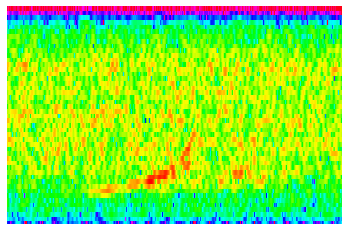

In [48]:
import shutil

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

def create_spectrogram(file_path):
    samples, sample_rate = librosa.core.load(file_path)
    
    # Compute spectrogram
    D = librosa.stft(samples, n_fft=1024, hop_length=64, window="han", center=False)  # STFT of y
    
    # Normalize to decibals
    S_dB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_dB, sample_rate


def show_or_save_spectrogram(spec, sr, hop_length, y_axis='hz', x_axis='time', filename=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    ax.set_ylim((0, 1000))
    librosa.display.specshow(spec, sr=sr, y_axis=y_axis, x_axis=x_axis, hop_length=hop_length, cmap="hsv_r")

    if(filename):
#         plt.savefig(filename, dpi=78, bbox_inches='tight',pad_inches=0)
        fig = plt.gcf()
        img = fig2img(fig)
        plt.close('all')
    else:
        plt.show()

S_dB, sample_rate = create_spectrogram("./full_data/whale/train6.aiff")
show_or_save_spectrogram(S_dB, sample_rate, 64)

#### Loop through each sample and create and save spectrogram (this might take a while)

In [41]:
df = pd.read_csv(DATA_META_FILE)
df.head()

for index, row in df.iterrows():
    if index % 10 == 0:
        print(index)
        
    clip_name = row['clip_name']
    label = row['label']
    
    source_path = os.path.join(DATA_AUDIO_DIR, clip_name)

    spec_dst_path = None
    aiff_dst_path = None
    spec_filename = clip_name.replace(".aiff", ".png")
    
    if(label==0): #not whale
        spec_dst_path  = os.path.join(IMAGE_NOT_WHALE_DIR, spec_filename)
        aiff_dst_path = os.path.join(DATA_NOT_WHALE_AUDIO_DIR, clip_name)
    else: #whale
        spec_dst_path  = os.path.join(IMAGE_WHALE_DIR, spec_filename)
        aiff_dst_path = os.path.join(DATA_WHALE_AUDIO_DIR, clip_name)

    shutil.move(source_path, aiff_dst_path)

#     if(not os.path.exists(spec_dst_path)):
#         S_dB, sample_rate = create_spectrogram(source_path)
#         show_or_save_spectrogram(S_dB, sample_rate, 64, filename=spec_dst_path)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
1795

Test that it moved correctly

In [20]:
df = pd.read_csv(DATA_META_FILE)
df.head()

for index, row in df.iterrows():
    clip_name = row['clip_name']
    label = row['label']
    source_path = os.path.join(DATA_AUDIO_DIR, clip_name)
    not_whale_destination_path = os.path.join(DATA_NOT_WHALE_AUDIO_DIR, clip_name)
    whale_destination_path = os.path.join(DATA_WHALE_AUDIO_DIR, clip_name)

    if(label==0): #not whale
        assert(os.path.exists(not_whale_destination_path)), f"{clip_name} should be in {not_whale_destination_path}"
        assert not(os.path.exists(whale_destination_path)), "f{clip_name} should not be in {whale_destination_path}"
    else: #whale
        assert not(os.path.exists(not_whale_destination_path)), f"{clip_name} should not be in {not_whale_destination_path}"
        assert(os.path.exists(whale_destination_path)), f"{clip_name} should be in {whale_destination_path}"

In [42]:
!rm -rf full_data/audio; rm -rf full_data/labels.csv